In [1]:
import os.path  # For some basic file functionality
import re  # For regular expessions
import numpy as np

import audiolabel  # To work with TextGrids
import parselmouth  # To incorporate Praat features in this notebook
# To get general Praat functionality where native features don't exist
from parselmouth.praat import call as pcall  

import pandas as pd  # For managing dataframes
import seaborn as sns  # For plotting data
import matplotlib.pyplot as plt  # For plotting data

## Functions
First we need to define a couple of functions, for actions we're going to take often.

### get_freq_dist

This is a function that takes a sound object and a row from a datafarme that contains details from a token.  This row may contain any kind of information, but it must minimally include an ending time (T2).

As written, the function calculates the center of gravity, standard deviation, skewness, and kurtosis of the frequency distribution of the sound *during a window of 50ms, right-aligned to the ending time*, and returns a tuple (an unordered list) containing these values.  You can change this to any number of other windows, as we discussed.  I've included a commented out line showing how you change it so that it analyzes the whole window from the beginning of the token to the end of the token.

In [2]:
# arguments
#   TOKEN: a row of data from a dataframe with, minimally, a burst time
# returns
#   a tuple containing the center of gravity, SD, skewness, and kurtosis of the frequency 
#     distribution of PSND starting from 5ms before the determined burst time and ending at 
#     15ms after
def get_freq_dist(token, psnd):

    # cut out a part of PSND and turn it into a Spectrum object
    s = psnd.extract_part(token['burst_time']-0.005, token['burst_time']+0.015).to_spectrum()
    
    # generate values and return
    return [s.get_center_of_gravity(), s.get_standard_deviation(), s.get_skewness(), 
            s.get_kurtosis()]

### get_intensity_values

This function is similar to `get_freq_dist`, except that it gets intensity values, and it returns values the same 50ms window as `get_freq_dist` and the 50ms window *following* the end of the token.

In [3]:
# arguments
#   TOKEN: a row of data from a dataframe with, minimally, start (t1) and end times (t2) and a
#          burst time
#   PSND: a Parselmouth Sound object
# returns
#   a tuple containing the intensity of the burst (from 5ms before the determined burst time and 
#     ending 15ms after) and 20ms of the following vowel after the end of token)
def get_intensity_values(token, psnd):

    # cut out a part of PSND and find its intensity
    db_d = psnd.extract_part(token['burst_time']-0.005, token['burst_time']+0.015).get_intensity()
    db_v = psnd.extract_part(token['t2']+0.02, token['t2']+0.04).get_intensity()  
    
    # return values
    return [db_d, db_v]

### make_burst_df

This is a function that takes a sound object and TextGrid, and generates a dataframe containing word and burst information for each valid stimulus item in the TextGrid's `words` tier. 
The TextGrid should contain at least two tiers, named `words` and `phones`.  Other tiers may exist, and will be ignored.

As written, the function turns the TextGrid into a dataframe containing only the /d/s that are word onsets, then applies the frequency distribution function `get_freq_dist` to each.

In [4]:
# arguments
#   PSND: a Parselmouth Sound object
#   TG: a TextGrid object containing the tiers 'words' and 'phones'
# returns
#   a dataframe version of the TextGrid's 'words' tier with additional measurements: center of 
#     gravity, SD, skewness, and kurtosis of the frequency distribution of PSND starting from 50ms
def make_burst_df(psnd, tg):

    # turn the TG into a data frame 
    df = tg.as_df()[0]

    # populate the word tier
    df['word'] = df.center.apply(lambda x: tg.labels_at(x).word.text)  
    # determine if row's phone is the onset of the word
    df['word_onset'] = df.t1.apply(lambda x: tg.labels_at(x).word.t1 == x)  
    # restrict the dataframe to onset /d/s
    df = df[((df.text=='D') | (df.text=='d')) & (df.word_onset)]  

    df['burst_time'] = df.apply(get_burst_time, args=([psnd]), axis=1)

    # get and store the burst COG, SD, etc
    df['burstvalues'] = df.apply(get_freq_dist, args=([psnd]), axis=1)  
    # save each burst value in its own column
    df['cog'] = df.burstvalues.apply(lambda x: x[0])
    df['sd'] = df.burstvalues.apply(lambda x: x[1])
    df['skew'] = df.burstvalues.apply(lambda x: x[2])
    df['kurtosis'] = df.burstvalues.apply(lambda x: x[3])
    
    # get and store the intensity values
    df['dbvalues'] = df.apply(get_intensity_values, args=([psnd]), axis=1)  
    df['db_d'] = df.dbvalues.apply(lambda x: x[0])
    df['db_v'] = df.dbvalues.apply(lambda x: x[1])
    
    # return the dataframe, but only these columns
    return df[['word','t1','t2','burst_time','cog','sd','skew','kurtosis','db_d','db_v']]  

### get_burst_time

This is a function that takes a sound object and a row from the dataframe, and returns an approximate time of the burst within that sound.
This time is an absolute timestamp in relation to the whole audiofile, and not within the individual word itself.

As written, the function assumes that there is a burst located somewhere between the start and end time as defined by `token`, and does not return a likelihood of there being a burst.

In [5]:
# arguments
#   TOKEN: a row of data from a dataframe with, minimally, start (t1) and end times (t2)
#   PSND: a Parselmouth Sound object
# returns
#   the time between t1 and t2 that is most likely to be associated with a stop burst.
def get_burst_time(token, psnd):
    
    # The MFCC analysis requires a snippet of audio that is at least 50ms long, so if t2-t1 
    #   is shorter than 50ms, add 25ms to either side
    (t1, t2)=(token['t1'], token['t2'])
    if t2-t1 < 0.05:
        t1 = t1-0.025
        t2 = t2+0.025
    
    # get an MFCC object from t1 to t2
    mfcc = psnd.extract_part(t1, t2, preserve_times=True).to_mfcc()  
    m = np.transpose(mfcc.to_array())  # flip the rows and columns in this matrix

    diffs = []  # define an empty array of "differences", then populate it
    for i in range(len(m)-1):
        # as is, this script works best when looking at the very first (lowest frequency) 
        # coefficient.  I'm not sure why it works, but since it does I'm going to leave it that 
        # way.  If you find it isn't working, you can play around a little with the index ([0])
        diffs = diffs + [(np.transpose(mfcc.to_array())[i+1]-np.transpose(mfcc.to_array())[i])[0]]
    
    # turn the frame number back into a timestamp and return
    return mfcc.frame_number_to_time(np.argmax(np.abs(diffs))+2)  

This script assumes that the following data structure, where each subject has their own folder containing their recording and both English and Spanish aligned TextGrids:
```
./
./S01
./S01/S01_words.wav
./S01/S01_English_aligned.TextGrid
./S01/S01_Spanish_aligned.TextGrid
./S02
./S02/S02_words.wav
./S02/S02_English_aligned.TextGrid
./S02/S02_Spanish_aligned.TextGrid
./etc...
```
You can include other files in each subject's folder as you wish, and the script will just ignore them.

In [6]:
datadir = '.'  # Where's the data?  For now, set to current working directory, but can be changed.
# get the list of subjects, using regex to match
subjects = [f for f in os.listdir(datadir) if re.match('S\d\d',f)]  
subjects  # check the list of subjects

['S03', 'S06']

Now that we know what subjects there are, we should be able to predict the names of the audio and annotation files.

In [7]:
audiosuffix = '_words.wav'
engtgsuffix = '_words_English_aligned.TextGrid'
spatgsuffix = '_words_Spanish_aligned.TextGrid'

Ok!  Now we're ready to process the data!  We'll iterate through each subject, and send each pair of audio+textgrid to `make_burst_df` for processing, then combine the resulting data into a master single dataframe for further analysis.

In [8]:
# set up the master dataframe
df = pd.DataFrame(columns=['speaker','language','word','t1','t2','cog','sd','skew','kurtosis',
                           'db_d','db_v'])
voicing_hz_filter = 300  # set to a max f0 value; used for filtering out voicing

for s in subjects:  # iterate through the subjects
    
    # set up paths to the audio files and annotation textgrids
    wav_file = os.path.join(datadir,s,s+audiosuffix)
    tg_eng_file = os.path.join(datadir,s,s+engtgsuffix)
    tg_spa_file = os.path.join(datadir,s,s+spatgsuffix)

    # read the audiofile as a Parselmouth Sound object, and the annotations as labelmanagers
    psnd = parselmouth.Sound(wav_file)
    psnd = pcall(psnd, 'Filter (stop Hann band)...', 0, voicing_hz_filter, 100)  # filter voicing
    tg_eng = audiolabel.LabelManager(from_file=tg_eng_file,from_type='praat')
    tg_spa = audiolabel.LabelManager(from_file=tg_spa_file,from_type='praat')

    edf = make_burst_df(psnd, tg_eng)  # make a dataframe from the English words
    edf['language'] = 'English'  # add a language column and set it to 'English'
    edf['speaker'] = s  # add a column for speaker number
    sdf = make_burst_df(psnd, tg_spa)  # do the same thing for Spanish
    sdf['language'] = 'Spanish'
    sdf['speaker'] = s
    
    # join the two dataframes with the master dataframe, and add speaker as a column
    df = df.append(edf, sort=False)
    df = df.append(sdf, sort=False)

Let's have a sneak peek at the data!

In [9]:
df.head()

,speaker,language,word,t1,t2,cog,sd,skew,kurtosis,db_d,db_v,burst_time
2,S03,English,DEBRIEFING,16.916200,17.006000,9331.365901,9099.226682,0.217205,-1.829339,14.410470,31.786330,16.978600
13,S03,English,DEVICE,19.737004,19.775900,5570.126199,5475.245641,1.110131,0.322478,23.780175,25.817033,19.738951
21,S03,English,DECIBEL,29.242600,29.323864,2029.146224,3564.142688,3.577487,14.214614,26.296182,36.710653,29.298231
31,S03,English,DYNAMIC,38.437700,38.487500,2239.903179,4235.422109,3.135899,9.229153,24.647511,36.956379,38.450096
41,S03,English,DECENTRALIZED,63.137100,63.266800,7724.125832,7567.425843,0.325430,-1.663127,22.101828,34.533380,63.204450


We can use the intensity columns to calculate two different versions of relative intensity.  By saving both columns, we can compare them and make a choice later.

In [10]:
# greater than 1 means the burst is louder than the vowel, and higher values are louder bursts
df['db_ratio']=df.db_d/df.db_v  
# positive means the burst is louder than the vowel, and higher values are louder bursts
df['db_diff']=df.db_d-df.db_v  

In [11]:
df.to_csv('./specanalysis_demo_data.csv')  # write this data to a csv file

Now let's make some plots...

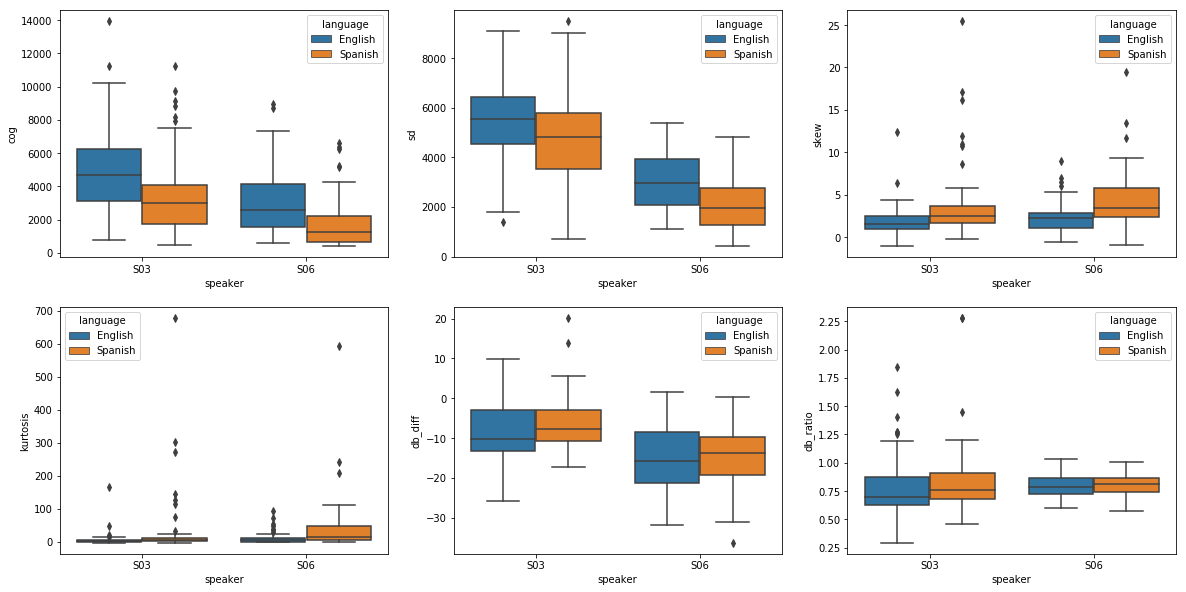

In [12]:
f, axes = plt.subplots(2, 3, figsize=(20, 10))  # set up an empty plot with 2x3 subplots
sns.boxplot(data=df, x='speaker', y='cog', hue='language', ax=axes[0,0])
sns.boxplot(data=df, x='speaker', y='sd', hue='language', ax=axes[0,1])
sns.boxplot(data=df, x='speaker', y='skew', hue='language', ax=axes[0,2])
sns.boxplot(data=df, x='speaker', y='kurtosis', hue='language', ax=axes[1,0])
sns.boxplot(data=df, x='speaker', y='db_diff', hue='language', ax=axes[1,1])
sns.boxplot(data=df, x='speaker', y='db_ratio', hue='language', ax=axes[1,2])